<a href="https://colab.research.google.com/github/jesrodriguez0816/Pnemonia_Prediction_Project/blob/main/Pneumonia_Prediction_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Prediction Project

Jessica Rodriguez

Flatiron School

Github: jesrodriguez0816

Github Repository: https://github.com/jesrodriguez0816/Pnemonia_Prediction_Project


## Overview

The goal of this project was to build a machine learning model to classify a dataset for chest x-ray images, screening them for pneumonia.
To achieve this goal, I built a **convolutional neural network** to **classify images as either pneumonia or non-pnemonia**.

The Paul Mooney dataset was used, found on Kaggle here: (https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia). It contains 5,683 images separated into two categories: "Pneumonia" and "Normal".

In [ ]:
# Import packages and statements
from tensorflow.random import set_seed
set_seed(321)

import numpy as np
np.random.seed(123)

#import module
import pickle

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 4.8 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283858 sha256=a11f39a4ac508fac05bb34eb77e6c4fd94e2d2d9a06a50e16d6f79f3bff63e30
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
# Import packages and statements
import os
import glob
from google.colab import drive

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers, optimizers, regularizers, activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, VGG19

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import lime
from lime import lime_base
from lime import lime_image
from skimage.segmentation import mark_boundaries

## Upload Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Get current directory
print(os.getcwd())

# Get contents of the directory
print(os.listdir())

/content
['.config', 'drive', 'sample_data']


In [ ]:
# Location of Zip File
drive_path = 'drive/MyDrive/Datasets/archive(6).zip'
local_path = '/content'

## Data Preprocessing and Exploration

* Obtain and Store the Data in a train / test / val split
* Find the total number of images
* Scale data
* Explore the data

In [ ]:

# File Paths
path_train_pneumonia = 'drive/MyDrive/chest_xray/train/PNEUMONIA'
path_train_normal = 'drive/MyDrive/chest_xray/train/NORMAL'
path_test_pneumonia = 'drive/MyDrive/chest_xray/test/PNEUMONIA'
path_test_normal = 'drive/MyDrive/chest_xray/test/NORMAL'
path_val_pneumonia = 'drive/MyDrive/chest_xray/val/PNEUMONIA'
path_val_normal = 'drive/MyDrive/chest_xray/val/NORMAL'

# How many images in each set
print('Train Pneumonia', len(os.listdir(path_train_pneumonia)))
print('Train Normal', len(os.listdir(path_train_normal)))
print('Test Pneumonia', len(os.listdir(path_test_pneumonia)))
print('Test Normal', len(os.listdir(path_test_normal)))
print('Val Pneumonia', len(os.listdir(path_val_pneumonia)))
print('Val Normal', len(os.listdir(path_val_normal)))

Train Pneumonia 3875
Train Normal 1341
Test Pneumonia 390
Test Normal 234
Val Pneumonia 8
Val Normal 8


In [ ]:
# Create data generators
# Ensure class_mode is binary
# Adjust batch size for training, testing, and validation sets (number of examples used in one iteration)
# Use a target size of 224x224 px for each image
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                    'drive/MyDrive/chest_xray/train',
                                                     target_size=(224, 224),
                                                     batch_size=5216,
                                                     class_mode='binary',
                                                     seed=123)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                    'drive/MyDrive/chest_xray/test',
                                                     target_size=(224, 224),
                                                     batch_size=624,
                                                     class_mode='binary',
                                                     seed=123)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                    'drive/MyDrive/chest_xray/val',
                                                     target_size=(224, 224),
                                                     batch_size=16,
                                                     class_mode='binary',
                                                     seed=123)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
# Create the data sets with the train/test/val splits
X_train, y_train = next(train_generator)
X_test, y_test = next(test_generator)
X_val, y_val = next(val_generator)

In [ ]:

# Determine which classes are which (o and 1)
print(y_test[:20])
print(y_test.shape)
train_generator.class_indices

[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1.]
(624,)


{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
# Check shapes of each set
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(5216, 224, 224, 3)
(624, 224, 224, 3)
(16, 224, 224, 3)


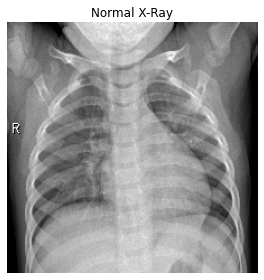

0.0


In [ ]:
# Look at example of normal xray
plt.imshow(np.squeeze(X_train[0]))
plt.axis('off')
plt.title('Normal X-Ray')
plt.tight_layout()
plt.show()
# Check the class label ('Normal':0)
print(y_train[0])

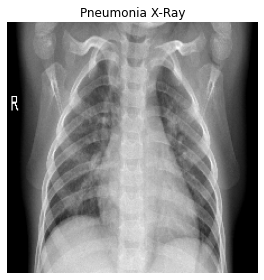

1.0


In [ ]:
# Look at example of pneumonia xray
plt.imshow(np.squeeze(X_train[1]))
plt.axis('off')
plt.title('Pneumonia X-Ray')
plt.tight_layout()
plt.show()
# Check class label ('Pneumonia':1)
print(y_train[1])

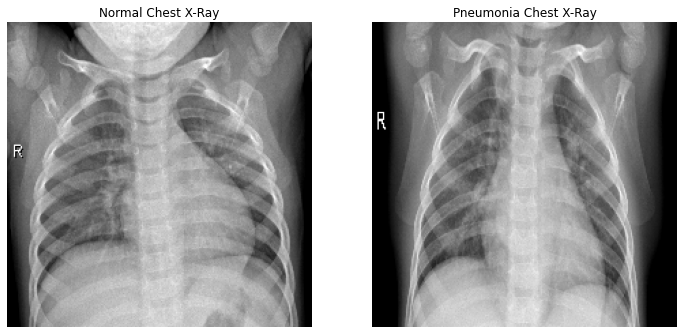

In [ ]:
# Compare the two types
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
axes[0].imshow(np.squeeze(X_train[0]))
axes[1].imshow(np.squeeze(X_train[1]))
axes[0].axis('off')
axes[1].axis('off')
axes[0].set_title('Normal Chest X-Ray')
axes[1].set_title('Pneumonia Chest X-Ray')
plt.show()

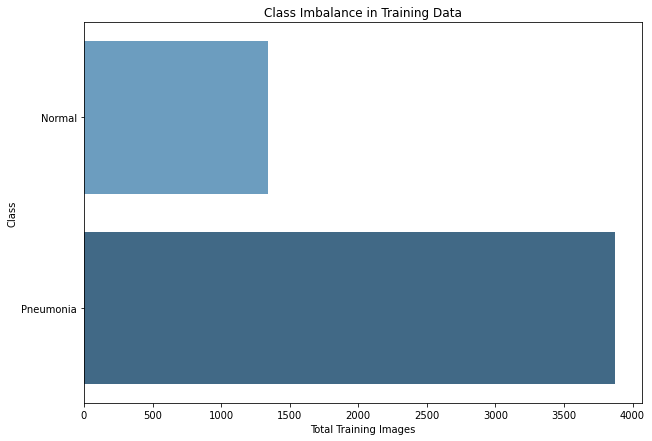

In [ ]:
# Create bar plot to visualize class imbalance of training data

plt.figure(figsize=(10,7))
sns.barplot(x=[sum(y_train==0), sum(y_train==1)],
            y=['Normal', 'Pneumonia'],
            palette='Blues_d')
plt.title('Class Imbalance in Training Data')
plt.ylabel('Class')
plt.xlabel('Total Training Images')
plt.show()

According to the bar plot, there are far more pneumonia images than normal images.

## Baseline CNN
This model will be our reference point. It will include the following:
* 3 convolutional layers (building blocks to produce an image)
* 3 max pooling layers (to downsample previous convolutional layers)
* 1 fully connected layer

In [ ]:
baseline = models.Sequential()

baseline.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(224, 224, 3)))
baseline.add(MaxPooling2D((2, 2)))

baseline.add(Conv2D(32, (3, 3), activation='relu'))
baseline.add(MaxPooling2D(2, 2))

baseline.add(Conv2D(64, (3, 3), activation='relu'))
baseline.add(MaxPooling2D((2, 2)))

baseline.add(Flatten())
baseline.add(Dense(64, activation='relu'))
baseline.add(Dense(1, activation='sigmoid'))

baseline.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc'])

In [ ]:
# Look at summary to see all layers
baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [ ]:
history = baseline.fit(X_train,
                       y_train,
                       epochs=20,
                       batch_size=50,
                       validation_data=(X_val, y_val))

Epoch 1/20
105/105 [==============================] - 13s 22ms/step - loss: 0.3330 - acc: 0.8549 - val_loss: 0.3336 - val_acc: 0.8125
Epoch 2/20
105/105 [==============================] - 2s 19ms/step - loss: 0.1086 - acc: 0.9597 - val_loss: 1.2485 - val_acc: 0.6250
Epoch 3/20
105/105 [==============================] - 2s 19ms/step - loss: 0.0939 - acc: 0.9663 - val_loss: 0.2036 - val_acc: 0.8750
Epoch 4/20
105/105 [==============================] - 2s 19ms/step - loss: 0.0667 - acc: 0.9753 - val_loss: 0.1787 - val_acc: 0.8750
Epoch 5/20
105/105 [==============================] - 2s 19ms/step - loss: 0.0623 - acc: 0.9762 - val_loss: 0.3407 - val_acc: 0.7500
Epoch 6/20
105/105 [==============================] - 2s 19ms/step - loss: 0.0644 - acc: 0.9776 - val_loss: 0.2570 - val_acc: 0.8750
Epoch 7/20
105/105 [==============================] - 2s 19ms/step - loss: 0.0410 - acc: 0.9852 - val_loss: 0.1633 - val_acc: 0.8750
Epoch 8/20
105/105 [==============================] - 2s 19ms/step -

In [ ]:
# Write a function to evaliate the results of the model
def evaluate_results(results, y_test=y_test):
  """
  input results of model fitting.
  output loss and accuracy curves, and confusion matrix
  """

  history = results.history
  plt.figure()
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.legend(['loss', 'val_loss'])
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  plt.figure()
  plt.plot(history['acc'])
  plt.plot(history['val_acc'])
  plt.legend(['acc', 'val_acc'])
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

  y_hat_test = results.model.predict(X_test)
  thresh = 0.5
  y_pred = (y_hat_test < thresh).astype(np.int)
  y_true = y_test.astype(np.int)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='0.5g')
  plt.xlabel('Predictions')
  plt.ylabel('Actuals')
  plt.title('Model Confusion Matrix')
  plt.show()

  print(classification_report(y_true, y_pred))
  print('\n')

  test_loss, test_acc = results.model.evaluate(X_test, y_test)
  print(f'Test Loss: {test_loss}')
  print(f'Test Acc: {test_acc}')

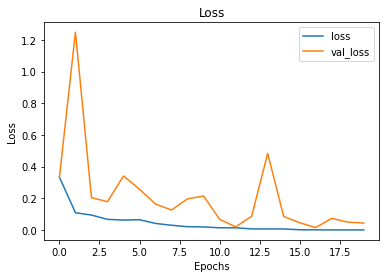

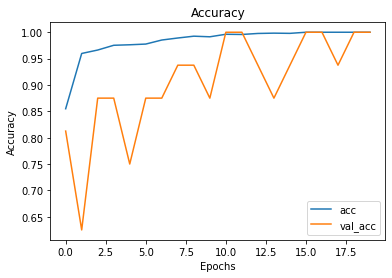

20/20 [==============================] - 0s 7ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

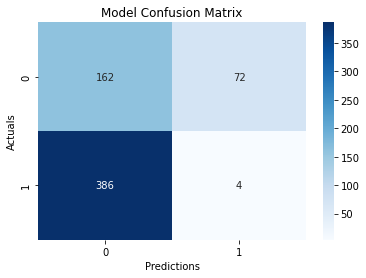

              precision    recall  f1-score   support

           0       0.30      0.69      0.41       234
           1       0.05      0.01      0.02       390

    accuracy                           0.27       624
   macro avg       0.17      0.35      0.22       624
weighted avg       0.14      0.27      0.17       624



20/20 [==============================] - 0s 8ms/step - loss: 3.8676 - acc: 0.7340
Test Loss: 3.8675806522369385
Test Acc: 0.7339743375778198


In [ ]:
evaluate_results(history)

**Results of Baseline:**

According to the confusion matrix, the model is mostly predicting the training class.

Due to a class imbalance-low validation and high training sets-this model is far from accurate. The model fits too well to the training set and is therefore "overfit".

For Iteration 2, I will implement an early stopping callback in attempt to balance the model. Essentially, this means that training will be stopped when the determined metric has stopped improving.

## CNN Iteration 2

* Address the class imbalance using class weights
based on the results of the baseline model's confusion matrix, which shows the model is predicting mostly one class (training)

* Experiment with more epochs (the number of passes of the entire training dataset the machine learning algorithm has completed) and early stopping
might prevent overfitting

* Reduce batch size
to improve accuracy

In [ ]:
from sklearn.utils import class_weight


In [ ]:
# Set up our class weights
weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)
weights_dict = dict(zip(np.unique(y_train), weights))
weights_dict

{0.0: 1.9448173005219984, 1.0: 0.6730322580645162}

In [ ]:

# Set up early stopping and learning rate reduction
# Set patience to 5
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5)
lr_redox = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
callbacks = [early_stop, lr_redox]

In [ ]:
# Build model iteration 2 with improvements above and another conv layer
model2 = models.Sequential()

model2.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(224, 224, 3)))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(2, 2))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))

model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc'])

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 64)      

In [ ]:
results = model2.fit(X_train,
                   y_train,
                   epochs=50,
                   batch_size=30,
                   validation_data=(X_val, y_val),
                   callbacks=callbacks)

Epoch 1/50
174/174 [==============================] - 3s 14ms/step - loss: 0.2590 - acc: 0.8944 - val_loss: 0.1804 - val_acc: 1.0000 - lr: 0.0010
Epoch 2/50
174/174 [==============================] - 2s 13ms/step - loss: 0.0997 - acc: 0.9611 - val_loss: 1.0933 - val_acc: 0.6250 - lr: 0.0010
Epoch 3/50
174/174 [==============================] - 2s 13ms/step - loss: 0.0807 - acc: 0.9707 - val_loss: 0.7326 - val_acc: 0.6875 - lr: 0.0010
Epoch 4/50
174/174 [==============================] - 2s 13ms/step - loss: 0.0596 - acc: 0.9785 - val_loss: 0.1538 - val_acc: 1.0000 - lr: 0.0010
Epoch 5/50
174/174 [==============================] - 2s 13ms/step - loss: 0.0634 - acc: 0.9768 - val_loss: 0.4822 - val_acc: 0.7500 - lr: 0.0010
Epoch 6/50
174/174 [==============================] - 2s 12ms/step - loss: 0.0397 - acc: 0.9854 - val_loss: 0.2357 - val_acc: 0.8750 - lr: 0.0010
Epoch 7/50
174/174 [==============================] - 2s 13ms/step - loss: 0.0300 - acc: 0.9895 - val_loss: 0.4007 - val_acc

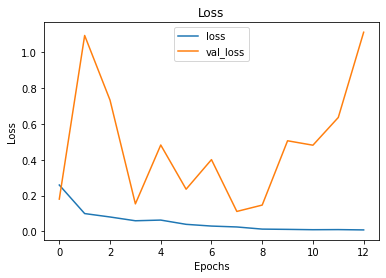

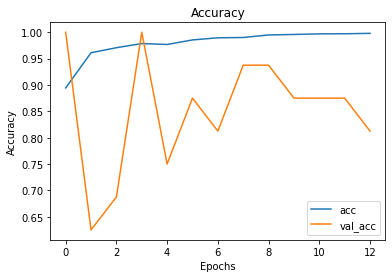

20/20 [==============================] - 0s 7ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

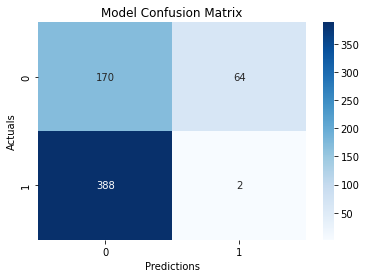

              precision    recall  f1-score   support

           0       0.30      0.73      0.43       234
           1       0.03      0.01      0.01       390

    accuracy                           0.28       624
   macro avg       0.17      0.37      0.22       624
weighted avg       0.13      0.28      0.17       624



20/20 [==============================] - 0s 8ms/step - loss: 2.5883 - acc: 0.7244
Test Loss: 2.5882515907287598
Test Acc: 0.7243589758872986


In [ ]:
evaluate_results(results)

**Results of Iteration 2:** 

Our accuracy remained largely the same, though the loss improved.

The training/validation ratio is heavily skewed. In the next iteratrion I will adjust the validation training split for greater balance.

## CNN Iteration 3

I will rework the validation size see if if this improves the loss and accuracy curves.

In [ ]:
mod3 = models.Sequential()

mod3.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(224, 224, 3)))
mod3.add(MaxPooling2D((2, 2)))

mod3.add(Conv2D(32, (3, 3), activation='relu'))
mod3.add(MaxPooling2D(2, 2))

mod3.add(Conv2D(64, (3, 3), activation='relu'))
mod3.add(MaxPooling2D((2, 2)))

mod3.add(Flatten())
mod3.add(Dense(64, activation='relu'))
mod3.add(Dense(1, activation='sigmoid'))

mod3.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc'])

In [ ]:
results = mod3.fit(X_train,
                   y_train,
                   epochs=50,
                   batch_size=30,
                   validation_split=.2,
                   class_weight=weights_dict,
                   callbacks=callbacks)

Epoch 1/50
140/140 [==============================] - 3s 19ms/step - loss: 0.3077 - acc: 0.8612 - val_loss: 0.0903 - val_acc: 0.9674 - lr: 0.0010
Epoch 2/50
140/140 [==============================] - 2s 14ms/step - loss: 0.1108 - acc: 0.9581 - val_loss: 0.0801 - val_acc: 0.9713 - lr: 0.0010
Epoch 3/50
140/140 [==============================] - 2s 14ms/step - loss: 0.0839 - acc: 0.9700 - val_loss: 0.0913 - val_acc: 0.9646 - lr: 0.0010
Epoch 4/50
140/140 [==============================] - 2s 14ms/step - loss: 0.0872 - acc: 0.9674 - val_loss: 0.0709 - val_acc: 0.9780 - lr: 0.0010
Epoch 5/50
140/140 [==============================] - 2s 14ms/step - loss: 0.0659 - acc: 0.9763 - val_loss: 0.0914 - val_acc: 0.9684 - lr: 0.0010
Epoch 6/50
140/140 [==============================] - 2s 14ms/step - loss: 0.0479 - acc: 0.9818 - val_loss: 0.0685 - val_acc: 0.9818 - lr: 0.0010
Epoch 7/50
140/140 [==============================] - 2s 14ms/step - loss: 0.0435 - acc: 0.9825 - val_loss: 0.0781 - val_acc

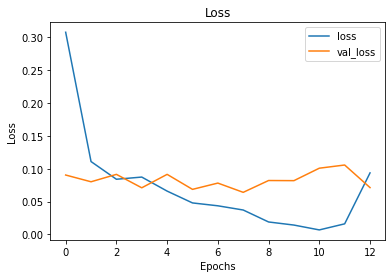

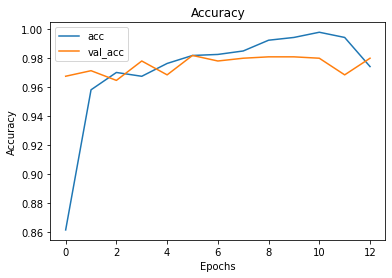

20/20 [==============================] - 0s 8ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

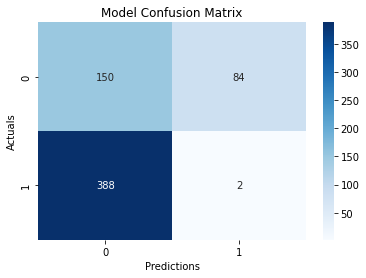

              precision    recall  f1-score   support

           0       0.28      0.64      0.39       234
           1       0.02      0.01      0.01       390

    accuracy                           0.24       624
   macro avg       0.15      0.32      0.20       624
weighted avg       0.12      0.24      0.15       624



20/20 [==============================] - 0s 8ms/step - loss: 1.6075 - acc: 0.7564
Test Loss: 1.607532262802124
Test Acc: 0.7564102411270142


In [ ]:
evaluate_results(results)

**Results of Iteration 3:**

The curves significantly improved. Model 3a improved a bit here. In the next iteration, I will keep this validation split instead of using the tiny validation set.

## CNN Iteration 4

In this iteration, I will add 2 convolutional layers per max pooling layer.

* I will also add convolutional layers will help detect more of the edges/nuances in the images with pneumonia

* I will also add another 2 blocks of layers (make the model deeper)

* Continue using 'RMSprop' as the optimizer



In [ ]:
mod4 = models.Sequential()

mod4.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(224, 224, 3)))
mod4.add(Conv2D(32, (3, 3), activation='relu'))
mod4.add(MaxPooling2D((2, 2)))

mod4.add(Conv2D(32, (3, 3), activation='relu'))
mod4.add(Conv2D(32, (3, 3), activation='relu'))
mod4.add(MaxPooling2D(2, 2))

mod4.add(Conv2D(64, (3, 3), activation='relu'))
mod4.add(Conv2D(64, (3, 3), activation='relu'))
mod4.add(MaxPooling2D((2, 2)))

mod4.add(Conv2D(64, (3, 3), activation='relu'))
mod4.add(Conv2D(64, (3, 3), activation='relu'))
mod4.add(MaxPooling2D((2, 2)))

mod4.add(Flatten())
mod4.add(Dense(128, activation='relu'))
mod4.add(Dense(64, activation='relu'))
mod4.add(Dense(1, activation='sigmoid'))

mod4.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

In [ ]:
results = mod4.fit(X_train,
                   y_train,
                   epochs=50,
                   batch_size=32,
                   validation_split=.2,
                   class_weight=weights_dict,
                   callbacks=[early_stop])


Epoch 1/50
131/131 [==============================] - 6s 33ms/step - loss: 0.7239 - acc: 0.5690 - val_loss: 0.3311 - val_acc: 0.8697
Epoch 2/50
131/131 [==============================] - 3s 25ms/step - loss: 0.3898 - acc: 0.8545 - val_loss: 0.3203 - val_acc: 0.8755
Epoch 3/50
131/131 [==============================] - 3s 25ms/step - loss: 0.2438 - acc: 0.9104 - val_loss: 0.1160 - val_acc: 0.9550
Epoch 4/50
131/131 [==============================] - 3s 25ms/step - loss: 0.1926 - acc: 0.9264 - val_loss: 0.1024 - val_acc: 0.9598
Epoch 5/50
131/131 [==============================] - 3s 25ms/step - loss: 0.1567 - acc: 0.9439 - val_loss: 0.1918 - val_acc: 0.9502
Epoch 6/50
131/131 [==============================] - 3s 25ms/step - loss: 0.1187 - acc: 0.9566 - val_loss: 0.1277 - val_acc: 0.9540
Epoch 7/50
131/131 [==============================] - 3s 26ms/step - loss: 0.0965 - acc: 0.9616 - val_loss: 0.0845 - val_acc: 0.9732
Epoch 8/50
131/131 [==============================] - 3s 25ms/step - 

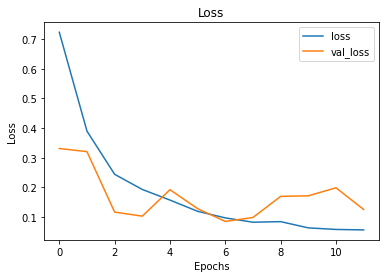

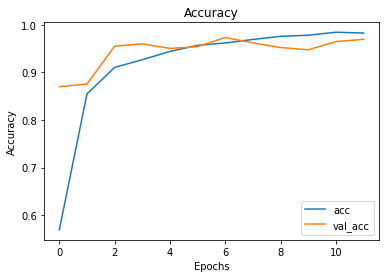

20/20 [==============================] - 0s 14ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

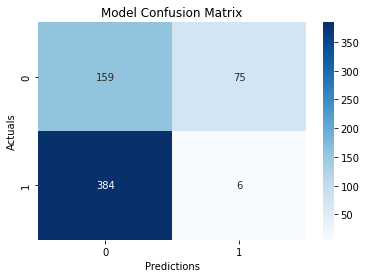

              precision    recall  f1-score   support

           0       0.29      0.68      0.41       234
           1       0.07      0.02      0.03       390

    accuracy                           0.26       624
   macro avg       0.18      0.35      0.22       624
weighted avg       0.16      0.26      0.17       624



20/20 [==============================] - 0s 11ms/step - loss: 2.4703 - acc: 0.7356
Test Loss: 2.470308542251587
Test Acc: 0.7355769276618958


In [ ]:
evaluate_results(results)

**Results of Iteration 4:**

There is significant model improvement in this iteration! According to the classification report and confusion matrix, the model is prediction normal x-rays very well.

Only a few "normal" images were classified as having pneumonia (False Positives). However, there are still many images with pneumonia misclassified as normal (False Negatives). 

I will do another iteration on this model to improve accuracy.

## CNN Iteration 5

In this iteration, I attempt to pull more features out of images by deepening the neural network.

In [ ]:
mod5 = models.Sequential()

mod5.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape=(224, 224, 3)))
mod5.add(Conv2D(32, (3, 3), activation='relu'))
mod5.add(MaxPooling2D((2, 2)))

mod5.add(Conv2D(32, (3, 3), activation='relu'))
mod5.add(Conv2D(32, (3, 3), activation='relu'))
mod5.add(MaxPooling2D(2, 2))

mod5.add(Conv2D(64, (3, 3), activation='relu'))
mod5.add(Conv2D(64, (3, 3), activation='relu'))
mod5.add(MaxPooling2D((2, 2)))

mod5.add(Conv2D(64, (3, 3), activation='relu'))
mod5.add(Conv2D(64, (3, 3), activation='relu'))
mod5.add(MaxPooling2D((2, 2)))

mod5.add(Conv2D(128, (3, 3), activation='relu'))
mod5.add(Conv2D(128, (3, 3), activation='relu'))
mod5.add(MaxPooling2D((2, 2)))

mod5.add(Flatten())
mod5.add(Dense(128, activation='relu'))
mod5.add(Dense(64, activation='relu'))
mod5.add(Dense(1, activation='sigmoid'))

mod5.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

In [ ]:
results = mod5.fit(X_train,
                   y_train,
                   epochs=50,
                   batch_size=32,
                   validation_split=.2,
                   class_weight=weights_dict,
                   callbacks=[early_stop])

Epoch 1/50
131/131 [==============================] - 5s 30ms/step - loss: 0.7211 - acc: 0.4583 - val_loss: 0.6933 - val_acc: 0.3228
Epoch 2/50
131/131 [==============================] - 3s 26ms/step - loss: 0.8777 - acc: 0.5216 - val_loss: 0.3419 - val_acc: 0.8410
Epoch 3/50
131/131 [==============================] - 3s 26ms/step - loss: 0.4675 - acc: 0.8011 - val_loss: 0.2688 - val_acc: 0.8870
Epoch 4/50
131/131 [==============================] - 3s 26ms/step - loss: 0.2952 - acc: 0.8816 - val_loss: 0.1348 - val_acc: 0.9540
Epoch 5/50
131/131 [==============================] - 3s 26ms/step - loss: 0.2157 - acc: 0.9135 - val_loss: 0.1085 - val_acc: 0.9626
Epoch 6/50
131/131 [==============================] - 3s 26ms/step - loss: 0.1768 - acc: 0.9360 - val_loss: 0.3866 - val_acc: 0.8448
Epoch 7/50
131/131 [==============================] - 3s 27ms/step - loss: 0.1785 - acc: 0.9439 - val_loss: 0.0938 - val_acc: 0.9684
Epoch 8/50
131/131 [==============================] - 3s 27ms/step - 

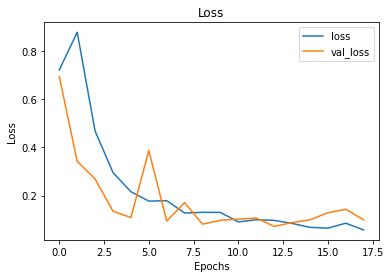

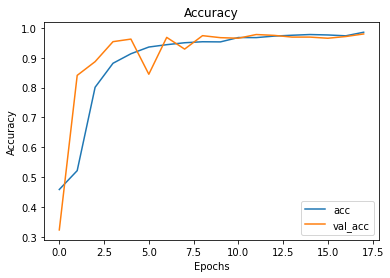

20/20 [==============================] - 0s 11ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

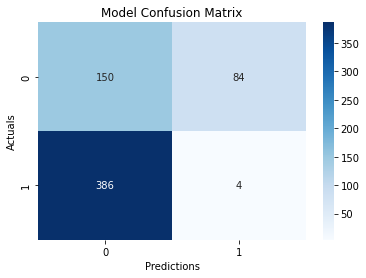

              precision    recall  f1-score   support

           0       0.28      0.64      0.39       234
           1       0.05      0.01      0.02       390

    accuracy                           0.25       624
   macro avg       0.16      0.33      0.20       624
weighted avg       0.13      0.25      0.16       624



20/20 [==============================] - 0s 11ms/step - loss: 4.1887 - acc: 0.7532
Test Loss: 4.188652515411377
Test Acc: 0.7532051205635071


In [ ]:
evaluate_results(results)

**Results of Iteration 5**

When we look at all the models, model 5 has the best accuracy (75%), and less False Negatives than most of the other models.

**Which model is the best fit?**

In diagnosing pneumonia, the best practice is to reduce the number of False Negatives.

**Iteration 5** has less false negatives and less false positives than most of the other models.  Iteration 5 also has an accuracy score of 75%. It will be considered our final, best model.

In [ ]:
# Save Model 5 as final model
final_cnn_path = 'drive/MyDrive/Datasets/final_pre_trained_cnn.hd5'

mod5.save(final_cnn_path)

In [ ]:
# Reload model
final_model = models.load_model(final_cnn_path)

## Image Feature Exploration

Use the Lime package to explore the features that lead to each classification.

I implemented Lime with information from [this article](https://towardsdatascience.com/how-to-explain-image-classifiers-using-lime-e364097335b4).

1/1 [==============================] - 0s 98ms/step
True Class: 1.0
Predicted Class: 1


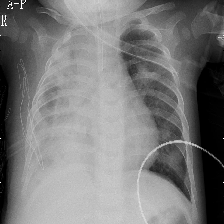

In [ ]:

# Get random image and label
label = y_train[2]
img = X_train[2]

img = img.astype('double')

# Get model pred
pred = mod5.predict(np.array([img]))
pred_class = int(pred.round())

# Print true class, predicted class and image
print('True Class:', label)
print('Predicted Class:', pred_class)
array_to_img(img)

In [ ]:
# Make an explainer
explainer = lime_image.LimeImageExplainer()

In [ ]:

explanation = explainer.explain_instance(img, mod5.predict, top_labels=2,
                                         hide_color=None, num_samples=2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 25ms/step
True Class: 0.0
Predicted Class: 0


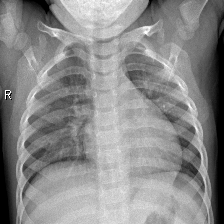

In [ ]:
  # Get random image and label
label = y_train[1]
img = X_train[1]

# Get model prediction
pred = mod5.predict(np.array([img]))
pred_class = int(pred.round())

# Print true class, predicted class and image
print('True Class:', label)
print('Predicted Class:', pred_class)
array_to_img(img)

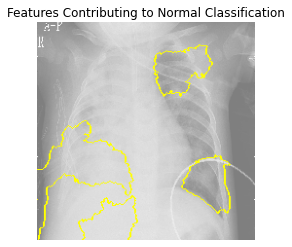

In [ ]:
# Use Lime to display features contributing to the pneumonia classification
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                            positive_only=True,
                                            num_features=5)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.title('Features Contributing to Normal Classification')
plt.show()

1/1 [==============================] - 0s 19ms/step
True Class: 1.0
Predicted Class: 0


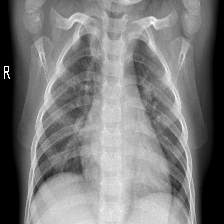

In [ ]:
# Get a random image at index 2
label2 = y_train[2]
img2 = X_train[2]
img2 = img2.astype('double')

# Get model prediction
pred2 = mod5.predict(np.array([img2]))
pred_class2 = int(pred.round())

# Print true class, predicted class and image
print('True Class:', label2)
print('Predicted Class:', pred_class2)
array_to_img(img2)

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


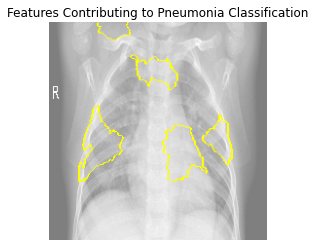

In [ ]:
explanation2 = explainer.explain_instance(img2, mod5.predict, top_labels=2,
                                         hide_color=None, num_samples=2000)

temp2, mask2 = explanation2.get_image_and_mask(explanation.top_labels[0],
                                            positive_only=True,
                                            num_features=5)
plt.imshow(mark_boundaries(temp2 / 2 + 0.5, mask2))
plt.axis('off')
plt.title('Features Contributing to Pneumonia Classification')
plt.show()

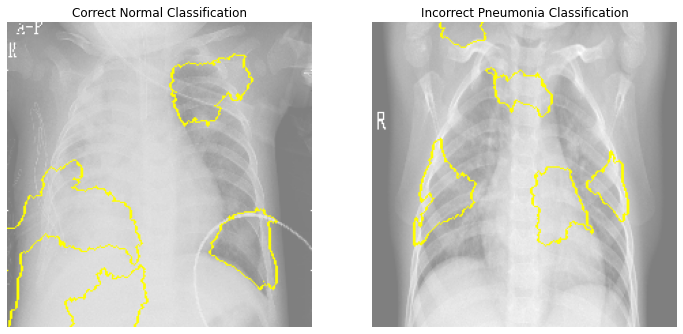

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
axes[0].imshow(mark_boundaries(temp / 2 + 0.5, mask))
axes[1].imshow(mark_boundaries(temp2 / 2 + 0.5, mask2))
axes[0].axis('off')
axes[1].axis('off')
axes[0].set_title('Correct Normal Classification')
axes[1].set_title('Incorrect Pneumonia Classification')
plt.show()

## Model Conclusion and Reccomendation
The model is imperfect; further tuning could be done to improve its accuracy score.

However, it can still be a useful tool for efficiency.

## Recommendations:

Each image should be reviewed by human eyes (tech and/or doctor) in addition to being trained on the model.
Each image should be saved as 224 x 224 px before being trained on the model
High-intensity pixel from the diaphragm may be adding noise to the model. The tech should crop out the diaphragm on each image to improve accuracy.
Follow-Up Work...What's Next?
To further improve this model, I would:

Explore methods to remove the diaphragm from each image to remove “noise” and improve accuracy
Retrain the model using smaller images (ex: 32 x 32 px) see if image features are more accurately highlighted
Research other methods to tune CNNs